#Project 9: Counterfactual Learning to Rank (Training)
As you will see in the course, due to the limitations associated with using expert annotations, ranking algorithms are frequently trained using much more widely available user click data. A simple approach might be to interpret clicked documents in response to a query as relevant and the rest as non-relevant. However, not all documents can be shown to the user in response to each query. Furthermore, user studies have shown that users are more likely to notice the documents at the top of the ranking and are progressively less likely to observe the documents at the bottom of the page. As such, any algorithm naively interpreting clicks as relevance is bound to be biased by the ranking algorithm used during click gathering, affecting our ability to learn the true document relevance.

In this project you will carry out a semi-synthetic experiment (simulations) to contrast traditional (biased) and bias-aware learning to rank learning methods (i.e. either a Click Model or Inverse Propensity Scoring based model). You will train the models, first briefly comparing their performance using naive and unbiased evaluation. You will then incorporate the bias-awareness into the training objective and contrast the resulting performance to that of naively trained models under various experimental conditions and hyperparameters.

**Dataset**: [Yahoo! Learning to Rank Challenge](https://webscope.sandbox.yahoo.com/catalog.php?datatype=c)

**Background reading**: [Unbiased Learning-to-Rank with Biased Feedback by Joachims et al. (2017)](https://arxiv.org/pdf/1608.04468.pdf) and [Policy-aware unbiased learning to rank for top-k rankings by Oosterhuis and de Rijke (2020)](https://arxiv.org/pdf/2005.09035.pdf)

**Features**: This project requires a high level of comfort with python and numpy as well as good knowledge of probability and linear algebra. Some minor data preprocessing (pytorch or tensorflow knowledge is not required but possibly useful). The simulations that are required in this project are done by taking query-document pairs from the yahoo dataset and then creating artificial user clicks based on some assumed user model+document relevances (described in detail in cited papers).

**Coach (contact person)**: Norman Knyazev (norman.knyazev@ru.nl)

# Pipeline for the assignment

We starten met de Yahoo! LTR dataset gegeven in de assignment. Hier elke regel in de dataset bestaat uit een  relevance $r$, een query(id) $q$, en een lijst of features $\mathbf{f}$.

1. We moeten een ranker trainen op een subset van onze data. Norman gaf zelf aan op dit te doen op een subset van features (1 feature zelfs mogelijk) met een subset van queries. In een ander paper gebruiken ze een subet van 20 queries. We hebben hier vrijheid in zolang de ranker maar niet te goed wordt.
2. Sample queries van de training data. In alle papers die ik gelezen heb samplen ze uniform en Norman zei ook dat die het makkelijkst is. Als we een query samplen is de output een lijst van urls/docs geassociëerd met de query die gesampled is.
3. Voor elke query die gesampled is, gebruiken we de preranker die op basis van de features een ranking van de urls genereerd.
4. Nu moeten we de user behavior modelleren. Wat we hiermee bedoelen is dat we moeten modelleren hoe een user de documenten in de ranking inspecteerd ($p(o)$), en wanneer een user op een document clickt ($c$). Een standaard model is om $p(o)$ te definiëren als $\frac{1}{k}$ met $k$ de rank in de ranking. We nemen dan aan dat een user clickt op het document als het relevant is($r=1$) en de user het document inspecteert. $p(c)$ is dus $p(o) \cdot r$. Met inverse propensity scoring is het idee dat we de documenten reweighten met een factor $\frac{1}{p(o)}$. Als een document $p(o) = \frac{1}{2}$ heeft samplen we het document (met $r, q, c, \mathbf{f}$) dus 2x zo vaak als een document met $p(o) = 1$).
5. De clicks worden als labels gebruikt om een ranker op te trainen. Deze ranker wordt de full ranker genoemd. Voor unbiased LTR gebruiken we de gereweighte data, en voor biased LTR gebruiken we de output zonder te reweighten. Voor de ranker zelf raadde Norman aan om een dot product tussen $f$ en een vector $w$ te gebruiken. Deze vector $w$ wordt dan aangepast tijdens training door de MSE tussen de output van de ranker en $c$ te gebruiken als loss functie. Voor unbiased wordt deze loss ook vermenigvuldigd met $p(o)$. We kunnen dan een ranker trainen met biased data en zonder biased data, en met een biased loss en zonder een biased loss. 

# Feedback for Project proposal
I would urge you to get a better understanding of the problem as currently the proposal appears to strongly paraphrase the project description :)

In particular, you may wish to look at section 5 in the linked paper by Oosterhuis and de Rijke to see how the data processing for model training will look like (the yahoo dataset itself is fine but there's a significant extra step).

The PyClick's limitation is that it doesn't accept document-query features and operates effectively as a look-up table. You can learn your own click model by following https://staff.fnwi.uva.nl/m.derijke/wp-content/papercite-data/pdf/hager-2022-are.pdf

Also which click model(s)?

It might also be too much to do click models AND inverse propensity scoring (it might also be ok) - you should make a clear plan for what you're planning to do and when to figure out whether you should do both or just one (and which one).

You can continue working on this topic, but you need to read articles and contact your coach to make the project tangible.

In [ ]:
#!pip install d2l==1.0.0a1.post0

In [ ]:
# Imports
from d2l import torch as d2l
import numpy as np
import tensorflow as tf
import time
import math
import torch
np.random.seed(9)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Data retrieval
We download the data via a transfer.sh link which expires every 14 days.  
Then we extract the file in the tar.bz2 and get the training, test and validation sets.  

In [ ]:
!wget "https://transfer.sh/42uKJg/ltrc_yahoo.tar.bz2"
!tar -xf ltrc_yahoo.tar.bz2

--2022-12-13 18:04:39--  https://transfer.sh/42uKJg/ltrc_yahoo.tar.bz2
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441419580 (421M) [application/x-bzip]
Saving to: ‘ltrc_yahoo.tar.bz2’

ltrc_yahoo.tar.bz2  100%[===================>] 420.97M  6.76MB/s    in 3m 28s  

2022-12-13 18:08:09 (2.03 MB/s) - ‘ltrc_yahoo.tar.bz2’ saved [441419580/441419580]



# Data processing
The files have to be read and stored into usable constructs.
In order to binarize the relevancy, we only consider the two highest relevance grades as relevant.

In [ ]:
def parse_data_line(line):
    """
        line : str
            relevance qid features
    """
    line_list = line.split(" ")

    # Get the relevance
    if int(line_list[0]) < 3:
        relevance = 0
    else:
        relevance = 1
    
    # Get the qid
    qid = int(line_list[1].split(":")[1])

    # Get the features
    urlrel_dict = {}
    for urlrel in line_list[2:]:
        urlrel_pair = urlrel.split(":")
        urlrel_dict[int(urlrel_pair[0])] = float(urlrel_pair[1])

    return relevance, qid, urlrel_dict

def process_file(file_path):
    data = {}
    with open(file_path, 'r') as data_file:
            for line in data_file:
                relevance, qid, urlrel_dict = parse_data_line(line)
                if qid in data:
                    data[qid].append([relevance, urlrel_dict])
                else:
                    data[qid] = [[relevance, urlrel_dict]]
    return data

def process_set(SET_NUMBER):
    test_set = process_file(f'set{SET_NUMBER}.test.txt')
    train_set = process_file(f'set{SET_NUMBER}.train.txt')
    val_set = process_file(f'set{SET_NUMBER}.valid.txt')

    return test_set, train_set, val_set

# Choose which set to use
SET_NUMBER = 2

test_set, train_set, val_set = process_set(SET_NUMBER)

### Obtain X_train, X_val, X_test and Y_train, Y_val, Y_test

In [ ]:
NR_FEATURES = 700

def obtain_features(data_row):
    # Obtain dict
    features_dict = data_row[1]
    # Obtain list of url with feature values
    indices = list(features_dict.keys())
    # Will contain features with 0s added, we use shape + 1 since feature values in Yahoo dataset start at 1. 
    # We remove the 1st element with index 0 afterwards
    features_vec = np.zeros(shape=NR_FEATURES+1)
    features_vec[indices] = list(features_dict.values())
    features_vec = features_vec[1:NR_FEATURES+1]
    return features_vec

def create_data_preranker(dataset):
    X_set, y_set = [], []
    #Sample 20 queries
    qids = np.unique(list(dataset.keys()))
    qids = np.random.choice(qids, 20, False)
    for qid in dataset:
        for data_row in dataset[qid]:
            X_set.append(obtain_features(data_row))
            y_set.append(data_row[0])
    return (np.array(X_set), np.array(y_set))

In [ ]:
# Create data sets
X_train, Y_train = create_data_preranker(train_set)
X_val, Y_val     = create_data_preranker(val_set)
X_test, Y_Test   = create_data_preranker(test_set)

# Preranker (With 10 features on 20 samples)

In [ ]:
def DCG(query_relevancy_labels, k):
    result = 0
    size = len(query_relevancy_labels)
    for i in range(min(k,size)):
        result += query_relevancy_labels[i] / math.log2(i+2)
    return result

def NDCG(query_relevancy_labels, k = 10):
    size = len(query_relevancy_labels)
    dcg = DCG(query_relevancy_labels, k)
    if dcg == 0:
        return 0
    else: 
        return dcg / DCG(query_relevancy_labels[query_relevancy_labels != 0],k)

def MSE(predictions, labels):
    assert(predictions.shape == labels.shape)
    return np.mean(0.5*(predictions-labels)**2)

def MSE_unbiased(predictions, labels, p_obs):
    assert(predictions.shape == labels.shape), "Predictions: " + str(predictions.shape) + "Labels: " + str(labels.shape)
    return np.mean((1/p_obs)*(0.5*(predictions-labels)**2))

def gradient_w(predictions, labels, X):
    assert(predictions.shape == labels.shape)
    gradient = (predictions - labels) @ X
    return gradient / len(predictions)

def gradient_w_unbiased(predictions, labels, X, p_obs):
    assert(predictions.shape == labels.shape)
    gradient = 1/p_obs*((predictions - labels)) @ X
    return gradient / len(predictions)

def MSE_tensor(predictions, labels):
    assert(predictions.shape == labels.shape)
    return torch.mean(0.5*(predictions-labels)**2)

In [ ]:
def train_preranker(batch_size = 128, lr = 0.001):
    X_train_small, Y_train_small = np.array(X_train[:20], copy=True), np.array(Y_train[:20], copy=True)
    X_val_small, Y_val_small     = np.array(X_val[:20], copy=True), np.array(Y_val[:20], copy=True)

    # Select 10 features to keep
    sample_features = np.random.choice(np.arange(0, 700, 1), 10)
    # Only the kept features will not be set to 0, X will also be set to 0 otherwise the weights will get updated
    indices = np.arange(0, 700, 1)
    indices = np.delete(indices, sample_features)

    X_train_small[:, indices] = 0
    X_val_small[:, indices] = 0

    # Initialize our model (weight vector), and only set weights not multiplied by a vector to 0.
    w = np.random.uniform(size=(NR_FEATURES))
    w[indices] = 0

    losses_train = []
    losses_val = []

    epoch_best = 0
    epochs_wo_improv = 1

    for e in range(200000):
        # Permute data
        permutation = np.random.permutation(len(X_train_small))
        X_train_small[np.arange(0,len(X_train_small), 1)] = X_train_small[permutation]
        Y_train_small[np.arange(0, len(Y_train_small), 1)] = Y_train_small[permutation]
        # Predict
        predictions = np.dot(X_train_small, w)
        predictions_val = np.dot(X_val_small, w)
        # Obtain loss
        loss = MSE(predictions, Y_train_small)
        loss_val = MSE(predictions_val, Y_val_small)
        # Update w
        w = w - lr*gradient_w(predictions, Y_train_small, X_train_small)
        losses_train.append(loss)
        losses_val.append(loss_val)
        #Early stopping 
        #Keep track of minimum
        if(e >= 1 and loss_val < min(losses_val[epoch_best:-1])):
            epoch_best = e
            #Store optimal weights in w_min
            w_pr = np.copy(w) 
        if(e >= epochs_wo_improv and (epoch_best <= e-epochs_wo_improv)):
            print("No improvement for 1 epoch, training finished.")
            break
    return w, w_pr, losses_train, losses_val

w, w_pr, losses_train, losses_val = train_preranker(batch_size = 128, lr = 0.001)

No improvement for 1 epoch, training finished.


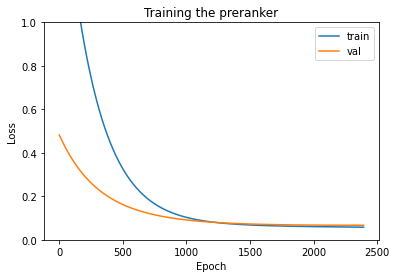

In [ ]:
import matplotlib.pyplot as plt

def plot_preranker(losses_train, losses_val):
    plt.ylim(0,1)
    plt.plot(losses_train, label='train')
    plt.plot(losses_val, label='val')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training the preranker")
    plt.legend()
    plt.show()

plot_preranker(losses_train, losses_val)

# Sample queries

In [ ]:
# Obtain query ids
qids_train = np.fromiter(train_set.keys(), dtype=int)
qids_val = np.fromiter(val_set.keys(), dtype=int)
qids_test = np.fromiter(test_set.keys(), dtype=int)

# All data
sampled_qs_train = np.random.permutation(qids_train)
sampled_qs_val = np.random.permutation(qids_val)
sampled_qs_test = np.random.permutation(qids_test)

# Model user behavior

In [ ]:
#Function adds p(o) and c as columns to the data
def add_user_behavior(relevances, nr_clicks, max_nr_clicks, click_noise = 0.1):
    p_obss = []
    clickss = []
    #Iterate over each url in the ranking
    for i, relevance in enumerate(relevances):
        #p_obs is 1/rank
        p_obs = 1/(i+1)
        p_obss.append(p_obs)
        #Cases (r=0,o=0)->p(c)=0, (r=0, o=1)->p(c)=0.1, (r=1,o=0)->p(c)=0, (r=1,o=1)->p(c)=1 below
        #r = 0
        if(relevance == 0):
            rand_p_obs = np.random.uniform(0., 1.)
            #o=1
            if(rand_p_obs < p_obs):
                #click noise
                if(np.random.uniform(0., 1.) < click_noise):
                    click = 1
                else:
                    click = 0
            #o=0
            else:
                click = 0
            nr_clicks += click
            clickss.append(click)
            #Check if we exceeded max nr of clicks
            if nr_clicks >= max_nr_clicks:
                #Return array of p_obs left and array of zero clicks left
                clicks_so_far = np.array(clickss)
                p_obs_so_far = np.array(p_obss)
                clicks_left = np.zeros(shape = (len(relevances) - len(clicks_so_far)))
                p_obs_left = np.zeros(shape = (len(relevances) - len(p_obs_so_far)))
                for j in range(len(p_obs_left)):
                    p_obs_left[j] = float(1/(j+len(p_obs_so_far)+1))
                p_obss = list(np.concatenate((p_obs_so_far, p_obs_left)))
                clickss = list(np.concatenate((clicks_so_far, clicks_left)))
                assert p_obs_left[len(p_obs_left)-1] == float(1/len(relevances))
                assert len(p_obss) == len(clickss)
                assert len(clickss) == len(relevances)
                break
        #r = 1
        else:
            #Model randomness of clicking
            rand_p_obs = np.random.uniform(0., 1.)
            #o = 1
            if(rand_p_obs < p_obs):
                click = 1
            #o = 0
            else:
                click = 0
            nr_clicks += click
            clickss.append(click)
            #Check if we exceeded max nr of clicks
            if nr_clicks >= max_nr_clicks:
                #Return array of p_obs left and array of zero clicks left
                clicks_so_far = np.array(clickss)
                p_obs_so_far = np.array(p_obss)
                clicks_left = np.zeros(shape = (len(relevances) - len(clicks_so_far)))
                p_obs_left = np.zeros(shape = (len(relevances) - len(p_obs_so_far)))
                for j in range(len(p_obs_left)):
                    p_obs_left[j] = float(1/(j+len(p_obs_so_far)+1))
                assert p_obs_left[len(p_obs_left)-1] == float(1/len(relevances))
                p_obss = list(np.concatenate((p_obs_so_far, p_obs_left)))
                clickss = list(np.concatenate((clicks_so_far, clicks_left)))
                assert len(p_obss) == len(clickss)
                assert len(clickss) == len(relevances)
                break

    return p_obss, clickss

# Generate data with clicks, and data for val + test (no clicks necessary)

In [ ]:
def generate_clicks(w, sampled_qs, data_set, click_simulations_per_query = 10, max_nr_clicks = 7500):
    start = time.time()
    data_wclicks = {}
    clicks = {}
    p_obs_dir = {}
    nr_clicks = 0
    nr_queries_wo_rel = 0

    for sampled_q in sampled_qs:
        urls = np.array(data_set[sampled_q])
        features = []
        for data_row in urls:
            features.append(obtain_features(data_row))
        scores = np.dot(features, w)
        
        ranking = [list(urls[:,0]), features, list(scores)]
        
        #sort based on ranking
        indices = np.argsort(np.array(ranking[2]))
        relevances = np.array(ranking[0])[indices]
        features = np.array(ranking[1])[indices]
        scores = np.array(ranking[2])[indices]
        
        p_obs_ = np.arange(1, len(data_set[sampled_q])+1, 1)
        p_obs_ = np.ones(shape=(len(data_set[sampled_q]),)) / p_obs_
        p_obs_dir[sampled_q] = p_obs_

        data_wclicks[sampled_q] = [relevances, features, scores]

        clicks[sampled_q] = np.zeros(shape=(len(data_set[sampled_q]), click_simulations_per_query))
          
    #Calculate the clicks for each query
    for i in range(click_simulations_per_query):
        if nr_clicks >= max_nr_clicks:
            i -= 1
            break
        else:   
            q_idx = 0
            for sampled_q in sampled_qs:
                relevances = data_wclicks[sampled_q][0]
                
                p_obs, clicks_sim = add_user_behavior(relevances, nr_clicks, max_nr_clicks)
                nr_clicks += sum(clicks_sim)
                clicks[sampled_q][:,i] = clicks_sim #/ np.array(p_obs)
                #assert np.array(clicks_sim).shape == np.array(p_obs).shape
                #p_obs_dir[sampled_q] = p_obs
                if nr_clicks >= max_nr_clicks:
                    break
                q_idx += 1

    #Calculate average clickthrough rate and create final return object
    for sampled_q in sampled_qs[0:q_idx]:
        relevances = data_wclicks[sampled_q][0]
        features   = data_wclicks[sampled_q][1]
        scores     = data_wclicks[sampled_q][2]
        data_wclicks[sampled_q] = [relevances, features, scores, p_obs_dir[sampled_q], np.mean(clicks[sampled_q][:,0:i+1], axis=1)]
        if sum(np.mean(clicks[sampled_q][:,0:i+1], axis=1)) == 0:
            nr_queries_wo_rel += 1
        
    for sampled_q in sampled_qs[q_idx:]:
        if i == 0:
            relevances = data_wclicks[sampled_q][0]
            features   = data_wclicks[sampled_q][1]
            scores     = data_wclicks[sampled_q][2]
            clicks[sampled_q] = np.zeros(shape=(len(data_set[sampled_q]),))
            data_wclicks[sampled_q] = [relevances, features, scores, p_obs_dir[sampled_q], clicks[sampled_q]]
            nr_queries_wo_rel += 1
        else:
            relevances = data_wclicks[sampled_q][0]
            features   = data_wclicks[sampled_q][1]
            scores     = data_wclicks[sampled_q][2]
            data_wclicks[sampled_q] = [relevances, features, scores, p_obs_dir[sampled_q], np.mean(clicks[sampled_q][:,0:i], axis=1)]
            if sum(np.mean(clicks[sampled_q][:,0:i], axis=1)) == 0:
                nr_queries_wo_rel += 1
    print("Queries without relevance: " + str(nr_queries_wo_rel))

    end = time.time()
    print((end-start))
    print("Clicks generated: " + str(nr_clicks))
    return data_wclicks
        
MAX_NR_CLICKS = 100000

data_wclicks_train = generate_clicks(w, sampled_qs_train, set2_train, click_simulations_per_query = 1000, max_nr_clicks = MAX_NR_CLICKS)
data_wclicks_val = generate_clicks(w, sampled_qs_val, set2_val, click_simulations_per_query = 1000, max_nr_clicks = int(MAX_NR_CLICKS*(len(set2_val)/len(set2_train))))

4.7367963790893555
Clicks generated: 7509
3.3225033283233643
Clicks generated: 1355


In [ ]:
def generate_clicks_train(w, sampled_qs_train, train_set, click_simulations_per_query = 10, max_nr_clicks = 7500):
    # How many time we simulates clicks for the queries, and the max number of clicks we generate
    start = time.time()
    data_wclicks_train = {} 
    nr_clicks = 0
    # Iterate over sampled queries
    for sampled_q in sampled_qs_train:        
        # Obtain urls of query for scoring
        urls = np.array(train_set[sampled_q])
        features = []
        for data_row in train_set[sampled_q]:
            features.append(obtain_features(data_row))
        scores = np.dot(features, w)
        # ranking will be returned
        ranking = []
        ranking.append(list(urls[:,0]))
        ranking.append(features)
        ranking.append(list(scores))

        # Sort based on ranking
        indices = np.argsort(np.array(ranking[2]))
        relevances = (np.array(ranking[0])[indices])
        features = (np.array(ranking[1])[indices])
        scores = (np.array(ranking[2])[indices])
        # Distinguish on whether we already generated enough clicks
        if(nr_clicks >= max_nr_clicks):
            clicks = np.zeros(shape=(len(train_set[sampled_q]),))
            p_obs, _ = add_user_behavior(relevances)
            data_wclicks_train[sampled_q] = [relevances, features, scores, p_obs, clicks]
        else:
            # Obtain average clickthrough rate
            clicks = np.zeros(shape=(len(train_set[sampled_q]), click_simulations_per_query))
            for i in range(click_simulations_per_query):
                p_obs, clicks_sim = add_user_behavior(relevances)
                nr_clicks += sum(clicks_sim)
                clicks[:,i] = clicks_sim 
                # We have generated necessary amount of clicks, return dictionary over mean of nr simulations so far
                if(nr_clicks >= max_nr_clicks):
                    data_wclicks_train[sampled_q] = [relevances, features, scores, p_obs, np.mean(clicks[:,0:i+1], axis=1)]
                    break
            # If we have not exceeded max clicks, dictionary is mean over whole clicks array
            if(nr_clicks < max_nr_clicks):
                data_wclicks_train[sampled_q] = [relevances, features, scores, p_obs, np.mean(clicks, axis=1)]
    end = time.time()
    print((end-start))
    print("Clicks generated: " + str(nr_clicks))
    return data_wclicks_train

data_wclicks_train = generate_clicks_train(w, sampled_qs_train, train_set, click_simulations_per_query = 10, max_nr_clicks = 7500)

5.690744876861572
Clicks generated: 6829


In [ ]:
def generate_clicks_val(w, sampled_qs_val, val_set, click_simulations_per_query = 10):
    data_wclicks_val = {}
    nr_clicks = 0
    # Iterate over sampled queries
    for sampled_q in sampled_qs_val:
        # Obtain urls of query for scoring
        urls = np.array(val_set[sampled_q])
        features = []
        for data_row in val_set[sampled_q]:
            features.append(obtain_features(data_row))
        scores = np.dot(features, w)
        # ranking will be returned, and will
        ranking = []
        ranking.append(list(urls[:,0]))
        ranking.append(features)
        ranking.append(list(scores))
        # Sort based on ranking
        indices = np.argsort(np.array(ranking[2]))
        relevances = (np.array(ranking[0])[indices])
        features = (np.array(ranking[1])[indices])
        scores = (np.array(ranking[2])[indices])

        # Average clickthrough rate
        clicks = np.zeros(shape=(len(val_set[sampled_q]), click_simulations_per_query))
        for i in range(click_simulations_per_query):
            p_obs, clicks_sim = add_user_behavior(relevances)
            nr_clicks += sum(clicks_sim)
            clicks[:,i] = clicks_sim 
        
        # Obtain p(o)s and click_labels of ranking and extend to lists
        data_wclicks_val[sampled_q] = [relevances, features, scores, p_obs, np.mean(clicks, axis=1)]
    return data_wclicks_val

data_wclicks_val = generate_clicks_val(w, sampled_qs_val, val_set, click_simulations_per_query = 10)

In [ ]:
def generate_clicks_test(sampled_qs_test, test_set):
    data_wclicks_test = {} 
    # Iterate over sampled queries
    for sampled_q in sampled_qs_test:
        # Obtain urls of query for scoring
        urls = np.array(test_set[sampled_q])
        features = []
        for data_row in test_set[sampled_q]:
            features.append(obtain_features(data_row))
        relevances = urls[:,0]

        data_wclicks_test[sampled_q] = [relevances, features]
    return data_wclicks_test

data_wclicks_test = generate_clicks_test(sampled_qs_test, test_set)

# Full ranker

In [ ]:
def create_batches(x_train, y_train, p_obs, batch_size):
    batches = []
    total_samples = x_train.shape[0]
    # Create the batches where there are enough samples 
    x_train_batches = np.split(x_train[:(total_samples - (total_samples % batch_size))], total_samples // batch_size)
    y_train_batches = np.split(y_train[:(total_samples - (total_samples % batch_size))], total_samples // batch_size)
    p_obs_batches = np.split(p_obs[:(total_samples - (total_samples % batch_size))], total_samples // batch_size)
    
    # Create the final smaller batch
    if total_samples/batch_size != 0:
        x_train_batches.append(x_train[total_samples - (total_samples % batch_size):])
        y_train_batches.append(y_train[total_samples - (total_samples % batch_size):])
        p_obs_batches.append(p_obs[total_samples - (total_samples % batch_size):])

    # Merge the batches for X_train and y_train together
    for i in range(len(x_train_batches)):
        batches.append((x_train_batches[i], y_train_batches[i], p_obs_batches[i]))

    return batches

In [ ]:
import math

ORACLE = False
UNBIASED = True
EPOCHS = 100

#Glorot initialization
w = np.random.normal(0, np.sqrt(2/(700+1)), size=(NR_FEATURES))
lr = 0.001

losses = []
losses_val = []

ndcgs = []
ndcgs_val = []

#Variables used for early stopping
epoch_best = 0
epochs_wo_improv = 5

start = time.time()
for e in range(EPOCHS):
    #Permute data
    permutation = np.random.permutation(len(sampled_qs_train))
    sampled_qs_train = sampled_qs_train[permutation]
    pw_losses_q = []
    losses_q = []
    ndcg_q = []
    #Sample queries
    for q in sampled_qs_train:
        X_train = np.array(data_wclicks_train[q][1])
        if ORACLE:
            Y_train = np.array(data_wclicks_train[q][0])
        else:
            Y_train = np.array(data_wclicks_train[q][4])
        P_obs = np.array(data_wclicks_train[q][3])
        #Obtain test prediction and loss
        predictions = np.dot(X_train, w)
        #Obtain indices of elements after sorting on score of prediction, this is necessary to rerank the labels in the NDCG calcualtion
        indices = np.flip(np.argsort(predictions))
        if(UNBIASED):
            loss = MSE_unbiased(predictions, Y_train, P_obs)
            w = w - lr*gradient_w_unbiased(predictions, Y_train, X_train, P_obs)
        else:
            loss = MSE(predictions, Y_train)
            w = w - lr*gradient_w(predictions, Y_train, X_train)
   
        losses_q.append(loss)
        ndcg = NDCG(Y_train[indices], 10)
        ndcg_q.append(ndcg)
        

    #Obtain validation ndcg
    ndcg_q_val = []
    ndcg_q_val_rel = []
    mse_val = []
    pw_losses_q_val = []
    for q_val in sampled_qs_val:
        X_val = np.array(data_wclicks_val[q_val][1])
        if ORACLE:
            Y_val = np.array(data_wclicks_val[q_val][0])
        else:
            Y_val = np.array(data_wclicks_val[q_val][4])
        predictions_val = np.dot(X_val, w)
        indices_val = np.flip(np.argsort(predictions_val))        
        ndcg_val = NDCG(Y_val[indices_val], 10)
        ndcg_q_val.append(ndcg_val)
        if UNBIASED:
            P_obs = np.array(data_wclicks_val[q_val][3])
            mse_val.append(MSE_unbiased(predictions_val, Y_val, P_obs))
        else:
            mse_val.append(MSE(predictions_val, Y_val))
        pw_loss_val = pairwise_loss(predictions_val, Y_val)
        pw_losses_q_val.append(pw_loss_val)

            
    loss_val = np.mean(mse_val)
    losses_val.append(loss_val)
    
    loss = np.mean(losses_q)
    losses.append(loss)
    
    ndcg = np.mean(ndcg_q)
    ndcgs.append(ndcg)
    ndcg_val = np.mean(ndcg_q_val)
    ndcgs_val.append(ndcg_val)
    
    print("Epoch " + str(e) + ": Validation loss: " + str(np.mean(mse_val)) + ", NDCG@10 " + str(np.mean(ndcg_q_val)))
    
    #Early stopping 
    #Keep track of minimum
    if(e >= 1 and loss_val < min(losses_val[epoch_best:-1])):
        epoch_best = e
        #Store optimal weights in w_min
        w_min = np.copy(w) 
        print(epoch_best)
    if(e >= epochs_wo_improv and (epoch_best <= e-epochs_wo_improv)):
        print("No improvement for 20 epochs, training finished.")
        break
    
end = time.time()
print("Training took " +str(end-start) +" seconds")
print("NDCG@10 train: " + str(ndcgs[e-1]))
print("NDCG@10 val: " + str(ndcgs_val[e-1]))

In [ ]:
def train_full_ranker(sampled_qs_train, data_wclicks_train, sampled_qs_val, data_wclicks_val, unbiased = True, epochs = 100, lr = 0.001):
    w = np.random.normal(0, np.sqrt(2/(700+1)), size=(NR_FEATURES))
    losses_train = []
    losses_val = []
    ndcgs = []
    ndcgs_val = []

    # Variables used for early stopping
    epoch_best = 0
    epochs_wo_improv = 5

    start = time.time()
    for e in range(epochs):
        # Permute data
        permutation = np.random.permutation(len(sampled_qs_train))
        sampled_qs_train = sampled_qs_train[permutation]
        losses_q = []
        ndcg_q = []
        # Sample queries
        for q in sampled_qs_train:
            X_train = np.array(data_wclicks_train[q][1])
            Y_train = np.array(data_wclicks_train[q][4])
            P_obs = np.array(data_wclicks_train[q][3])
            # Obtain test prediction and loss
            predictions = np.dot(X_train, w)
            # Obtain indices of elements after sorting on score of prediction, this is necessary to rerank the labels in the NDCG calcualtion
            indices = np.flip(np.argsort(predictions))
            if(unbiased):
                loss = MSE_unbiased(predictions, Y_train, P_obs)
                w = w - lr * gradient_w_unbiased(predictions, Y_train, X_train, P_obs)
            else:
                loss = MSE(predictions, Y_train)
                w = w - lr*gradient_w(predictions, Y_train, X_train)
            losses_q.append(loss)
            ndcg = NDCG(Y_train[indices], 10)
            ndcg_q.append(ndcg)
            
        # Obtain validation ndcg
        ndcg_q_val = []
        mse_val = []
        for q_val in sampled_qs_val:
            X_val = np.array(data_wclicks_val[q_val][1])
            Y_val = np.array(data_wclicks_val[q_val][4])
            predictions_val = np.dot(X_val, w)
            indices_val = np.flip(np.argsort(predictions_val))    
            ndcg_val = NDCG(Y_val[indices_val], 10)
            ndcg_q_val.append(ndcg_val)
            mse_val.append(MSE(predictions_val, Y_val))

        # Validation metrics
        loss_val = np.mean(mse_val)
        losses_val.append(loss_val)
        
        loss = np.mean(losses_q)
        losses_train.append(loss)
        
        ndcg = np.mean(ndcg_q)
        ndcgs.append(ndcg)
        ndcg_val = np.mean(ndcg_q_val)
        ndcgs_val.append(ndcg_val)

        print("Epoch " + str(e) + ": Validation loss: " + str(np.mean(mse_val)) + ", NDCG@10 " + str(np.mean(ndcg_q_val)))

        # Early stopping
        if(e >= 1 and loss_val < min(losses_val[epoch_best:-1])):
            epoch_best = e
            # Store optimal weights in w_min
            w_min = np.copy(w) 
        if(e >= epochs_wo_improv and (epoch_best <= e-epochs_wo_improv)):
            print("No improvement for " +str(epochs_wo_improv) + " epochs, training finished.")
            break

    end = time.time()
    print("Training took " +str(end-start) +" seconds")
    print("NDCG@10 train: " + str(ndcgs[e-1]))
    print("NDCG@10 val: " + str(ndcgs_val[e-1]))
    return w, w_min, losses_train, losses_val, ndcgs, ndcgs_val

w, w_min, losses_train, losses_val, ndcgs, ndcgs_val = train_full_ranker(sampled_qs_train, data_wclicks_train, sampled_qs_val, data_wclicks_val, unbiased = True, epochs = 100, lr = 0.001)

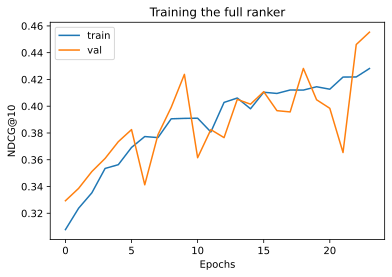

In [ ]:
# Training zonder batches 
import matplotlib.pyplot as plt

def plot_training_without_batches(ndcgs, ndcgs_val):
    plt.plot(ndcgs, label='train')
    plt.plot(ndcgs_val, label='val')
    plt.ylabel("NDCG@10")
    plt.xlabel("Epochs")
    plt.title("Training the full ranker")
    plt.legend()
    plt.show()

plot_training_without_batches(ndcgs, ndcgs_val)

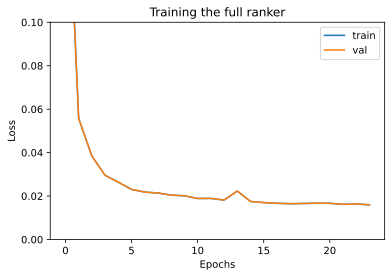

In [ ]:
def plot_loss_training_without_batches(losses_train, losses_val):
    plt.plot(losses_train, label='train')
    plt.plot(losses_train, label='val')
    plt.ylim(0,0.1)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Training the full ranker")
    plt.legend()
    plt.show()

plot_loss_training_without_batches(losses_train, losses_val)

# Evaluate on test set

In [ ]:
def arp(sorted_labels):
    ranks = np.arange(1, len(sorted_labels)+1, 1)
    return sum(sorted_labels*ranks)

def evaluate_test(w_min, sampled_qs_test, data_wclicks_test):
    ndcg_q_test = []
    arps = []
    for q_test in sampled_qs_test:
        X_test = np.array(data_wclicks_test[q_test][1])
        Y_test = np.array(data_wclicks_test[q_test][0])
        predictions_test = np.dot(X_test, w_min)
        indices_test = np.flip(np.argsort(predictions_test))        
        ndcg_test = NDCG(Y_test[indices_test], 10)
        ndcg_q_test.append(ndcg_test)
        arps.append(arp(Y_test[indices_test]))
    ndcg_test = np.mean(ndcg_q_test)
    arps = np.mean(arps)
    return ndcg_test, arps
    
ndcg_test, arps = evaluate_test(w_min, sampled_qs_test, data_wclicks_test)
ndcg_test_pr, arps_pr = evaluate_test(w_pr, sampled_qs_test, data_wclicks_test)
print(ndcg_test)
print(arps)

0.24174473796143933


# Implementation of neural network with pytorch

In [ ]:
def train(net, sampled_qs_train, num_epochs = 10, lr = 0.001):
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'ndcg_train', 'test loss', 'test accuracy', 'ndcg_test'])
    timer, num_batches = d2l.Timer(), len(sampled_qs_train)
    ndcgs = []
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        ndcg_q = []

        #Permute data
        permutation = np.random.permutation(len(sampled_qs_train))
        sampled_qs_train = sampled_qs_train[permutation]
        for i, q in enumerate(sampled_qs_train):
            X = torch.tensor(data_wclicks_train[q][1]).float().to(device)
            y = torch.tensor(data_wclicks_train[q][4]).float()[:, None].to(device)

            y_hat = net(X)

            indices = torch.flatten(torch.argsort(y_hat, dim=0, descending = True)).cpu().detach().numpy()
            ndcg = NDCG(np.array(data_wclicks_train[q][4])[indices], 10)
            ndcg_q.append(ndcg)

            loss = MSE_tensor(y_hat, y)
            loss.backward()
            
            optimizer.step()
            
            with torch.no_grad():
                metric.add(loss * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, np.mean(ndcg_q), None, None, None))
                
        test_loss, test_accuracy, test_ndcg = test(net)
        print(test_accuracy)
        print(test_ndcg)
        ndcgs.append(test_ndcg)
        animator.add(epoch + 1, (None, None, None, test_loss, test_accuracy, test_ndcg))
    return ndcgs

def test(net):
    net.eval()
    metric = d2l.Accumulator(3)
    ndcg_v = []
    with torch.no_grad():
        for i, q in enumerate(sampled_qs_val):
            X = torch.tensor(data_wclicks_val[q][1]).float().to(device)
            y = torch.tensor(data_wclicks_val[q][4]).float()[:, None].to(device)

            y_hat = net(X)

            # print(y_hat)
            # print(y)
            # print("____________")

            loss = MSE_tensor(y_hat, y)

            indices = torch.flatten(torch.argsort(y_hat, dim=0, descending = False)).cpu().detach().numpy()

            ndcg = NDCG(np.array(data_wclicks_val[q][4])[indices], 10)
            ndcg_v.append(ndcg)

            metric.add(loss * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])

    test_loss = metric[0] / metric[2]
    test_accuracy = metric[1] / metric[2]
    print(ndcg_v)
    test_ndcg = np.mean(ndcg_v)
    print(test_loss)
    print(test_ndcg)
    return test_loss, test_accuracy, test_ndcg

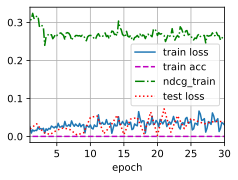

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(700, 64),
    torch.nn.Sigmoid(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(64, 32),
    torch.nn.Sigmoid(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(32, 1),
)

device = d2l.try_gpu() 
ndcgs = train(net, sampled_qs_train, num_epochs = 30, lr = 0.001)

In [ ]:
def test_testset(net):
    net.eval()
    metric = d2l.Accumulator(3)
    ndcg_t = []
    with torch.no_grad():
        for i, q in enumerate(sampled_qs_test):
            X = torch.tensor(data_wclicks_test[q][1]).float().to(device)
            y = torch.tensor(data_wclicks_test[q][0].astype('int32'))[:,None].to(device)

            y_hat = net(X)

            loss = MSE_tensor(y_hat, y)

            indices = torch.flatten(torch.argsort(y_hat, dim=0, descending = True)).cpu().detach().numpy()

            ndcg = NDCG(np.array(data_wclicks_test[q][0])[indices], 10)
            ndcg_t.append(ndcg)

            metric.add(loss * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])

    test_ndcg = np.mean(ndcg_t)
    return test_ndcg

test_testset(net)

0.1431514597200992

# Implementation of neural networks with multiple layers in numpy

In [ ]:
class Linear:
    def __init__(self, n_in, n_out):
        a = np.sqrt(6 / (n_in * n_out))
        self.W = np.random.uniform(-a, a, size=(n_in,n_out))
        #self.W = np.random.normal(0, np.sqrt(2/(700+1)), size=(NR_FEATURES))
        self.b = np.zeros((n_out,))
    
    def forward(self, x):
        y = np.dot(x, self.W)# + self.b
        return y

    def backward(self, x, dy):
        #print("x: " + str(x.shape))
        #print("dy: " + str(dy.shape))
        #print("W: " + str(self.W.shape))
        # given dy, compute the gradients for x, W and b
        #if dy.ndim == 1:
            #dy = np.expand_dims(dy, axis=1)
        #print("dy exp: " + str(dy.shape))
        dx = np.dot(dy, self.W.T)
        self.dW = np.dot(x.T, dy) 
        #self.db = np.sum(dy, axis=0) 
        return dx
    
    def step(self, step_size):
        self.W = self.W - step_size * self.dW  
        #self.b = self.b - step_size * self.db 
        
    def __str__(self):
        return 'Linear %dx%d' % self.W.shape

class Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

    def backward(self, x, dy):
        # compute the backward pass,
        # return the gradient for x given dy
        return dy * np.exp(-x) / (np.exp(-x) + 1) ** 2
    
    def step(self, step_size):
        # no weights, so no updates required
        return
    
    def __str__(self):
        return 'Sigmoid'

class Net:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        # compute the forward pass for each layer
        trace = []
        for layer in self.layers:
            # compute the forward pass
            y = layer.forward(x)
            # store the original input for the backward pass
            trace.append((layer, x))
            x = y
        # return the final output and the history trace
        return y, trace

    def backward(self, trace, dy):
        # compute the backward pass for each layer
        for layer, x in trace[::-1]:
            # print("dy: " + str(dy.shape))
            # print("dy squeeze " + str(np.squeeze(dy).shape))
            # print("x: " + str(x.shape))
            # compute the backward pass using the original input x
            dy = layer.backward(x, dy)

    def step(self, learning_rate):
        # apply the gradient descent updates of each layer
        for layer in self.layers:
            layer.step(learning_rate)

    def __str__(self):
        return '\n'.join(str(l) for l in self.layers)

In [ ]:
def train_full_ranker_multiple_layers(net, sampled_qs_train, data_wclicks_train, sampled_qs_val, data_wclicks_val, unbiased = True, epochs = 100, lr = 0.001):
    losses_train = []
    losses_val = []
    ndcgs = []
    ndcgs_val = []

    start = time.time()
    for e in range(epochs):
        # Permute data
        permutation = np.random.permutation(len(sampled_qs_train))
        sampled_qs_train = sampled_qs_train[permutation]
        losses_q = []
        ndcg_q = []

        for q in sampled_qs_train:
            X_train = np.array(data_wclicks_train[q][1])
            Y_train = np.array(data_wclicks_train[q][4])
            P_obs = np.array(data_wclicks_train[q][3])

            predictions, trace = net.forward(X_train)

            indices = np.flip(np.argsort(predictions))

            if(unbiased):
                if len(predictions) == 1:
                    predictions_squeezed = np.array(predictions[0])
                else:
                    predictions_squeezed = np.squeeze(predictions)
                loss = MSE_unbiased(predictions_squeezed, Y_train, P_obs)
                dy = (np.squeeze(predictions) - Y_train) / len(predictions)
                dy_ = np.reshape(dy, (len(dy), 1))
            else:
                loss = MSE(predictions, Y_train)
                gradient = gradient_w(predictions, Y_train, X_train)
                gradient.reshape(len(gradient_w(predictions, Y_train, X_train)), 1)
            net.backward(trace, dy_)
            net.step(lr)

            losses_q.append(loss)
            if Y_train.shape == (1,):
                ndcg = NDCG(Y_train[indices], 10)
            else:
                ndcg = NDCG(np.squeeze(Y_train[indices]), 10)
            #print(len(np.squeeze(Y_train[indices])))
            ndcg_q.append(ndcg)

        ndcg_q_val = []
        mse_val = []

        for q in sampled_qs_val:
            X_val = np.array(data_wclicks_val[q][1])
            Y_val = np.array(data_wclicks_val[q][4])
            p_obs = np.array(data_wclicks_val[q][3])
            predictions, trace = net.forward(X_val)
            indices = np.flip(np.argsort(predictions))
            if Y_val.shape == (1,):
                ndcg_val = NDCG(Y_val[indices], 10)
            else:
                ndcg_val = NDCG(Y_val[indices].reshape(len(Y_val),), 10)
            ndcg_q_val.append(ndcg)
            if len(predictions) == 1:
                predictions_squeezed = np.array(predictions[0])
            else:
                predictions_squeezed = np.squeeze(predictions)
            mse_val.append(MSE_unbiased(predictions_squeezed, Y_val, p_obs))

        # Validation metrics
        loss_val = np.mean(mse_val)
        losses_val.append(loss_val)
        
        loss = np.mean(losses_q)
        losses_train.append(loss)
        
        ndcg = np.mean(ndcg_q)
        ndcgs.append(ndcg)
        ndcg_val = np.mean(ndcg_q_val)
        ndcgs_val.append(ndcg_val)

        print("Epoch " + str(e) + ": Validation loss: " + str(np.mean(mse_val)) + ", NDCG@10 " + str(np.mean(ndcg_q_val)))

net = Net([
    Linear(700, 256),
    Sigmoid(),
    Linear(256, 1),
])

#train_full_ranker_multiple_layers(net, sampled_qs, data_wclicks_train, sampled_qs_val, data_wclicks_val, unbiased = True, epochs = 5, lr = 0.001)
train_full_ranker_multiple_layers(net, sampled_qs_train, data_wclicks_train, sampled_qs_val, data_wclicks_val, unbiased = True, epochs = 100, lr = 0.001)

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Epoch 0: Validation loss: 0.013600368433257137, NDCG@10 0.0
Epoch 1: Validation loss: 0.013123906105796581, NDCG@10 0.0
Epoch 2: Validation loss: 0.017589617423002215, NDCG@10 1.0
Epoch 3: Validation loss: 0.012335803106695744, NDCG@10 0.0
Epoch 4: Validation loss: 0.0167790298535019, NDCG@10 0.0
Epoch 5: Validation loss: 0.013079576416278325, NDCG@10 1.0
Epoch 6: Validation loss: 0.014380286441840133, NDCG@10 1.0
Epoch 7: Validation loss: 0.015010121941413542, NDCG@10 1.0
Epoch 8: Validation loss: 0.012467561453655449, NDCG@10 1.0
Epoch 9: Validation loss: 0.06325816680623536, NDCG@10 1.0
Epoch 10: Validation loss: 0.014005491735606489, NDCG@10 1.0
Epoch 11: Validation loss: 0.012799631608363584, NDCG@10 1.0
Epoch 12: Validation loss: 0.01270343086810482, NDCG@10 1.0
Epoch 13: Validation loss: 0.012356864857439937, NDCG@10 1.0
Epoch 14: Validation loss: 0.013321784332572698, NDCG@10 1.0
Epoch 15: Validation loss: 0.015296208248141232, NDCG@10 1.0
Epoch 16: Validation loss: 0.013444514